# **Cancer detection ML Project**


In [110]:
! pip install --upgrade torch

In [111]:
from torch.cuda import is_available, get_device_name

if is_available():
    print(f"The environment has a compatible GPU ({get_device_name()}) available.")
else:
    print(f"The environment does NOT have a compatible GPU model available.")

The environment has a compatible GPU (NVIDIA GeForce RTX 4050 Laptop GPU) available.


In [112]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

%matplotlib inline

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset, random_split
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

### Helper Functions

In [113]:
from numpy import clip , array
from matplotlib import pyplot as plt
from torch import Tensor

def imshow(inp: Tensor) -> None:
    """Imshow for Tensor."""
    inp = inp.cpu().numpy()
    inp = inp.transpose((1, 2, 0))
    mean = array([0.485, 0.456, 0.406])
    std = array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = clip(inp, 0, 1)
    plt.imshow(inp)
    plt.show()

In [114]:

import zipfile
from tqdm import tqdm

with zipfile.ZipFile("data_sample.zip", "r") as zip_ref:
    total_files = len(zip_ref.infolist())
    print(len(zip_ref.infolist()))

    for file in tqdm(zip_ref.infolist(), total=total_files):
        zip_ref.extract(file, "data_sample")

os.remove("data_sample/data_sample/.DS_Store")

8021


100%|██████████| 8021/8021 [00:05<00:00, 1449.81it/s]


In [115]:
labels_df = pd.read_csv("labels.csv")
labels_df.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

#### Visualizing some sample data


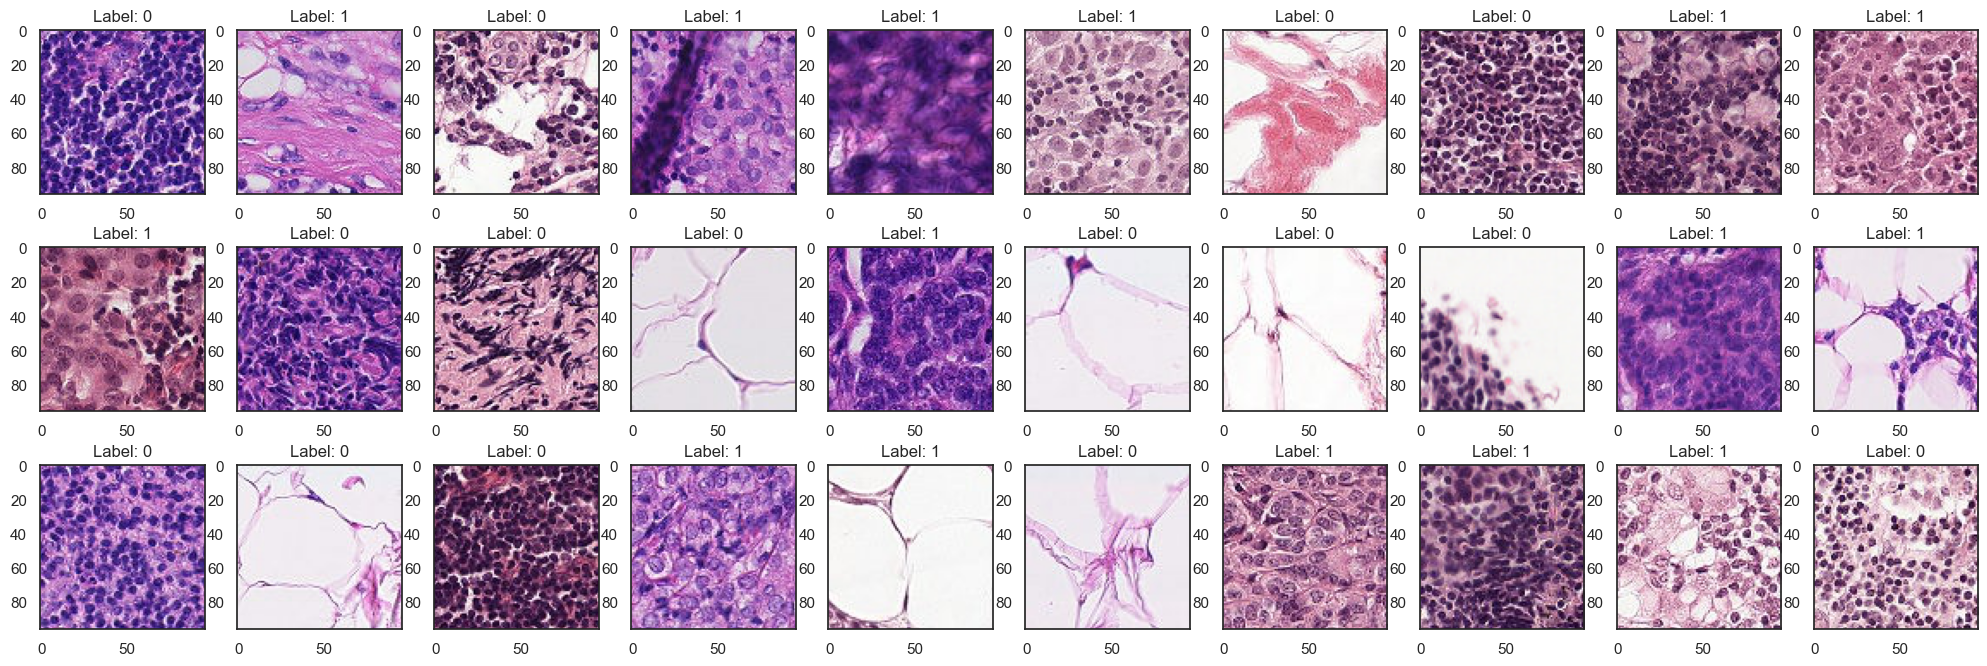

In [116]:
fig = plt.figure(figsize=(25, 8))
path2data = "./data_sample/data_sample"
train_imgs = os.listdir(path2data)

for idx, img in enumerate(np.random.choice(train_imgs, 30)):

    ax = fig.add_subplot(3, 30//3, idx+1)
    im = Image.open(path2data + "/" + img)
    plt.imshow(im)
    lab = labels_df.loc[labels_df["id"] == img.split('.')[0], 'label'].values[0]

    ax.set_title(f'Label: {lab}')


In [117]:
import csv
file_path = 'labels.csv'
with open(file_path, 'r') as csvfile:
  reader = csv.reader(csvfile)
  num_rows = sum(1 for row in reader)


## Data Preparation


In [118]:
class cancer_dataset(Dataset):
    def __init__(self, data_dir, transform, dataset_type=None):
        path2data = os.path.join(data_dir, "data_sample/data_sample")
        
        filenames = os.listdir(path2data)

        print("Number of files in the directory:", len(filenames))

        self.full_filenames = [os.path.join(path2data, f) for f in filenames]

        path2labels = os.path.join(data_dir, "labels.csv")
        labels_df = pd.read_csv(path2labels)

        labels_df.set_index("id", inplace=True)

        if dataset_type=="train":
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames][0:3608]
            self.full_filenames = [os.path.join(path2data, f) for f in filenames][0:3608]
            print("training dataset")
            
        elif dataset_type=="val":
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames][3608:3648]
            self.full_filenames = [os.path.join(path2data, f) for f in filenames][3608:3648]
            print("validation dataset")
            
        elif dataset_type=="test":
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames][3648:-1]
            self.full_filenames = [os.path.join(path2data, f) for f in filenames][3648:-1]
            print("testing dataset")
            
        else:
            self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]

        self.transform = transform

    def __len__(self):
        return len(self.full_filenames)

    def __getitem__(self, idx):
        img = Image.open(self.full_filenames[idx]) 
        img = self.transform(img)
        
        return img, self.labels[idx]

In [119]:
from torchvision import transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
composed_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=5),
    
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # transforms.RandomCrop((224, 224)),

    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

composed= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    ])

In [120]:
import os 
from os import listdir
from os.path import isfile, join 


mypath = "./data_sample/data_sample"

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [121]:
labels_df

id  label
0       f38a6374c348f90b587e046aac6079959adf3835      0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2       755db6279dae599ebb4d39a9123cce439965282d      0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4       068aba587a4950175d04c680d38943fd488d6a9d      0
...                                          ...    ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

[220025 rows x 2 columns]

In [122]:
data_dir = "./"
dataset_full = cancer_dataset(data_dir , transform=composed)

Number of files in the directory: 4009


In [123]:
img, label = dataset_full [19]
print(img.shape, torch.min(img), torch.max(img))

torch.Size([3, 224, 224]) tensor(-2.0357) tensor(2.6400)


In [124]:
training_set=cancer_dataset(data_dir , transform=composed_train,dataset_type="train")
 
validation_set=cancer_dataset(data_dir , transform=composed,dataset_type="val")
test_set=cancer_dataset(data_dir , transform=composed,dataset_type="test")
print(f'training dataset length: {len(training_set)}')
print(f'validation dataset length: {len(validation_set)}')
print(f'test dataset length: {len(test_set)}')


Number of files in the directory: 4009
training dataset
Number of files in the directory: 4009
validation dataset
Number of files in the directory: 4009
testing dataset
training dataset length: 3608
validation dataset length: 40
test dataset length: 360


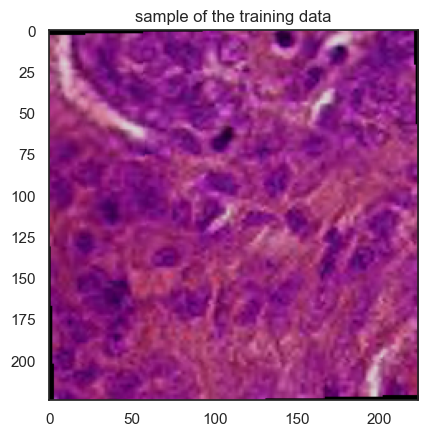

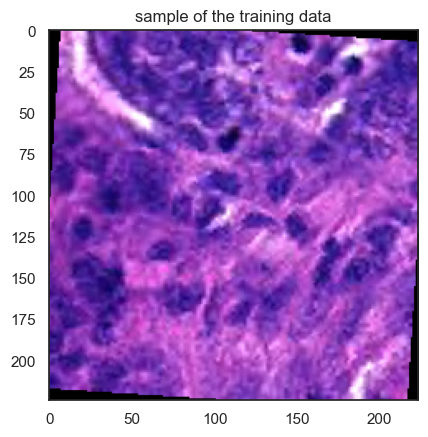

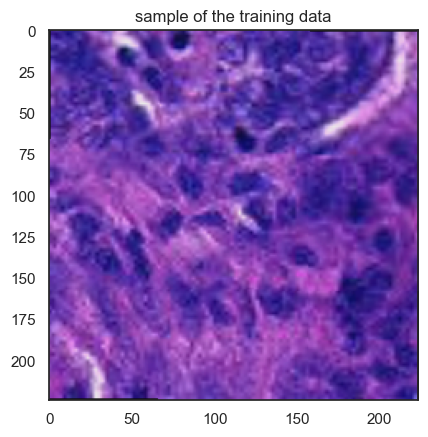

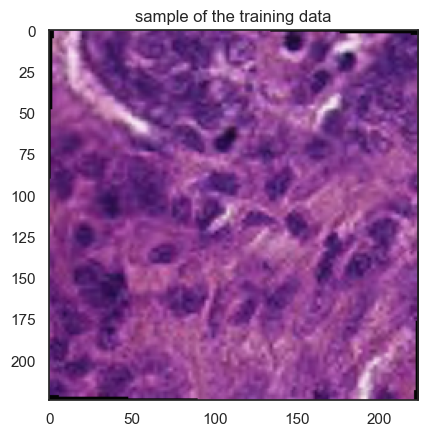

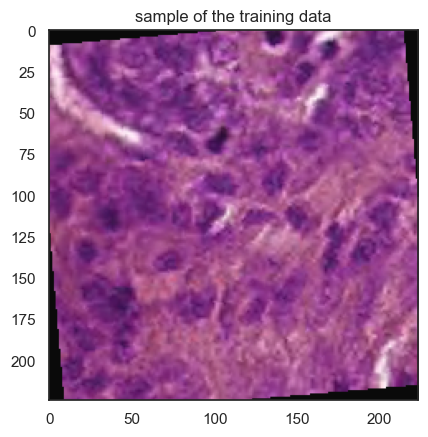

In [125]:
for i in range(5):
    plt.title("sample of the training data")
    imshow(training_set[2][0])


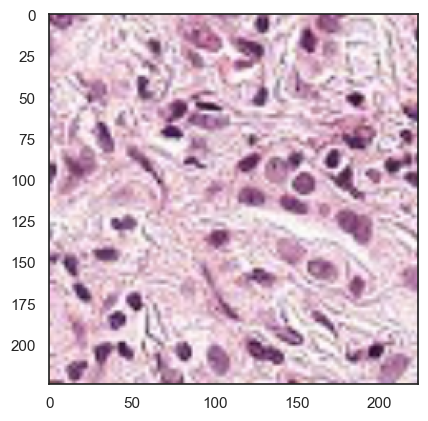

In [126]:
imshow(test_set[0][0])

In [127]:
train_loader = torch.utils.data.DataLoader(training_set, batch_size=10, shuffle=True, num_workers=0)

val_loader = torch.utils.data.DataLoader(validation_set, batch_size=10, shuffle=False, num_workers=1)


test_loader = torch.utils.data.DataLoader(test_set, batch_size=10, shuffle=False, num_workers=0)

num_classes = 2
print("done")

done


In [128]:
batch_size = 30

lr = 1e-4

n_epochs = 5

### Load Model



In [129]:
from torchvision import models

model = models.resnet34(pretrained = True)

In [130]:
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()

In [131]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr = lr)

In [132]:
num_classes = 2
model = models.resnet34(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

In [133]:
import matplotlib.pyplot as plt

train_loss_history = []
val_loss_history = []

for epoch in range(1): 
    running_loss = 0.0 

    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        train_loss_history.append(running_loss / len(train_loader))

   

        # Print the average loss every 100 iterations
        if i % 100 == 99:
            tqdm.write('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0 





 28%|██▊       | 100/361 [00:42<01:50,  2.36it/s]

[1,   100] loss: 0.688


 55%|█████▌    | 200/361 [01:25<01:11,  2.24it/s]

[1,   200] loss: 0.693


 83%|████████▎ | 300/361 [02:09<00:31,  1.94it/s]

[1,   300] loss: 0.706


100%|██████████| 361/361 [02:37<00:00,  2.29it/s]


In [134]:
# Test the model
correct = 0
total = 0 

with torch.no_grad():
    for data in tqdm(test_loader):
        images, labels = data 

        outputs = model(images)


        _, predicted = torch.max(outputs.data, 1)


        total += labels.size(0)

        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))


100%|██████████| 36/36 [00:12<00:00,  2.95it/s]

Accuracy of the network on the test images: 55 %
